# Reports
---

In this document, I use the labeled dataset from part 2 and do the correlation analysis with financial datas.

- First, I download data from yahoo finace, join the financial data with tweets data by time index.

- Then, I use market return as indicator(label = 1 if it is positive, label = 0 if it is negative).

- Then I use average sentiment scores of each label as independent variables to do regression analysis.

- After preparing the data, I do data analysis and write some comments.

Some changes here:

- Since after averaging tweets data, we have less than 300 data points, there is no need to use machine learning method such as random forest to do prediction. I use ols and logistic regression which have better interpretation. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/nlp_data/'

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import numpy as np
import pandas as pd
! pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.5 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 112 kB 74.2 MB/s 
     |████████████████████████████████| 4.0 MB 63.8 MB/s 
     |████████████████████████████████| 128 kB 59.3 MB/s 
     |████████████████████████████████| 110 kB 69.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


## Download stock price data and calculate returns

In [ ]:
# download stock market data
stocks = ['AAPL','AMZN','META','NVDA','TSLA'] # notice that Facebook has changed name
dictPrice = {}
for stock in stocks:
    data = yf.download(stock, start="2021-01-01", end="2022-03-07")
    dictPrice[stock]=data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# calculate returns
dictPrice['AAPL']['returns'] = dictPrice['AAPL']['Adj Close'].pct_change()

In [ ]:
def create_y(stock):
    price = dictPrice[stock]
    price['returns'] = price['Adj Close'].pct_change()
    price.loc[price['returns'] > 0, 'return_type'] = 1
    price.loc[price['returns'] <= 0, 'return_type'] = 0
    price = price.drop(columns = ['Open', 'High', 'Low', 'Close', 'Adj Close','Volume'])
    return price

In [ ]:
# get all values for 5 stocks
aapl_price = create_y('AAPL')
tsla_price = create_y('TSLA')
amzn_price = create_y('AMZN')
fb_price = create_y('META')
nvda_price = create_y('NVDA')

## Load tweets data and calculate average scores.

In [ ]:
# load the labeled data
path = '/content/drive/MyDrive/nlp_data/'

In [ ]:
def read_and_avg(path, stock):
    tweet = pd.read_csv(path+stock+'_scored.csv',parse_dates=['Est_date'], index_col = 'Est_date')
    tweet_df = tweet.resample('D').mean().dropna().drop(columns = ['pred','score'])
    return tweet_df

In [ ]:
aapl_df = read_and_avg(path, 'AAPL')
tsla_df = read_and_avg(path, 'TSLA')
fb_df = read_and_avg(path, 'FB')
amzn_df = read_and_avg(path, 'AMZN')
nvda_df = read_and_avg(path, 'NVDA')

In [ ]:
# shift one day to match the price data
aapl_df_lag = aapl_df.shift(periods=1,freq='D')
tsla_df_lag = tsla_df.shift(periods=1,freq='D')
fb_df_lag = fb_df.shift(periods=1,freq='D')
amzn_df_lag = amzn_df.shift(periods=1,freq='D')
nvda_df_lag = nvda_df.shift(periods=1,freq='D')

Now, we have finished all data preparation parts and will move to data analysis section.

## Why don't use regex to preprocess text data

Here I use the first 100 tweets from apple stock to illustrate.

In [ ]:
# load labeled data
other_aapl = pd.read_csv(path+'other_scored.csv',parse_dates=['Est_date'], index_col = 'Est_date')
other_aapl = other_aapl[:100]
other_aapl = other_aapl.drop(columns = ['anger', 'disgust', 'fear', 'joy',
       'neutral', 'sadness', 'surprise'])
aapl_df_compare = pd.read_csv(path+'AAPL_scored.csv',parse_dates=['Est_date'], index_col = 'Est_date')
aapl_df_compare = aapl_df_compare[:100]
aapl_df_compare = aapl_df_compare.drop(columns = ['anger', 'disgust', 'fear', 'joy',
       'neutral', 'sadness', 'surprise'])
# merge data
compare=pd.merge(other_aapl,aapl_df_compare, how='inner', left_index=True, right_index=True)
# check data frame to see the differences
compare.head(5)

,text_x,pred_x,label_x,score_x,text_y,pred_y,label_y,score_y
Est_date,,,,,,,,
2021-01-01 09:46:09,$qqq $spi $aapl $tsla $amzn perfect storm huge...,0,anger,0.406197,$qqq $spy we have the perfect storm for huge m...,0,anger,0.704889
2021-01-01 09:47:43,$qqq $aapl $tsla $spi $amzn point look bright ...,3,joy,0.789919,"$qqq $spy has a point, but look on the bright ...",5,sadness,0.380001
2021-01-01 09:49:26,$aapl earn month th g iphon sale quarter brainer,3,joy,0.878743,earnings this month on the $NUMBER$th. all of ...,6,surprise,0.755537
2021-01-01 10:10:05,$aapl aapl option analysi video http www youtu...,4,neutral,0.432858,aapl $NUMBER$-12-31 options analysis video: $URL$,4,neutral,0.889007
2021-01-01 10:11:18,$aapl bought share yesterday took transact fill,4,neutral,0.560684,i bought $NUMBER$ shares yesterday at $NUMBER$...,4,neutral,0.532586


In [ ]:
sum(compare['label_x'] == compare['label_y'])/len(compare)

0.5454545454545454

From the above example we see different text cleaning methods generate very different labeled results. Only 54% of the texts have the same label. Some are even opposite, like the second line in the above dataframe. This is because some special symbols in the text data also convey sentiment information. We cannot simply drop all of them. Hence, a big task for sentiment analysis is how to treat these special symbols and define text similarities. Thanks to the fast developing deep learning theories, we can use one of pre-trained model to handle these special things and get more precise results.



### Explanation for the sentiment score

The sentiment score we get from the model for each text can be explained as: this text conveys a% of angry emotion, b% of fear emotion, c% of disgust, d% of joy, etc. All emotions scores add up to 100%. This method makes sense because one text cannot be only one feeling. And the label is obtained by argmax function(which kind of emotion has the largest proportion).

## Data analysis section


- Hints: in this section, I do the analysis seperately for each stock.

- First I do descriptive statistical analysis, as shown in the first part. Then I do both regression analysis and logistic regression.  

- All texts that are hard to label are considered neutral, and thus most time I drop the neutral scores.

- All the pictures are downloaded and stored for further use, but tables are not and may require manual input when writing final report.

- I write some basic comments regarding each analysis result, but we can also come up with more findings, feel free to write more comments regarding results in the final report. 

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

## AAPL data analysis




### Data descriptions



In [ ]:
# merge data
aapl_merge=pd.merge(aapl_df,aapl_price, how='inner', left_index=True, right_index=True).dropna()

In [ ]:
# descriptions
aapl_merge.describe()

,anger,disgust,fear,joy,neutral,sadness,surprise,returns,return_type
count,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000
mean,0.084092,0.021029,0.044826,0.127576,0.376811,0.108405,0.237260,0.000994,0.515571
std,0.014298,0.005932,0.010606,0.013993,0.022545,0.013529,0.014741,0.016220,0.500624
min,0.055049,0.008538,0.025500,0.085568,0.307496,0.068469,0.196223,-0.041674,0.000000
25%,0.072419,0.016602,0.037488,0.117296,0.360789,0.099717,0.228129,-0.008421,0.000000
50%,0.082279,0.019951,0.043241,0.126771,0.378292,0.108331,0.238517,0.000613,1.000000
75%,0.094022,0.024947,0.050322,0.137372,0.392791,0.116265,0.245558,0.011989,1.000000
max,0.147945,0.040497,0.085690,0.168184,0.445155,0.150589,0.286247,0.069778,1.000000


#### Return patterns

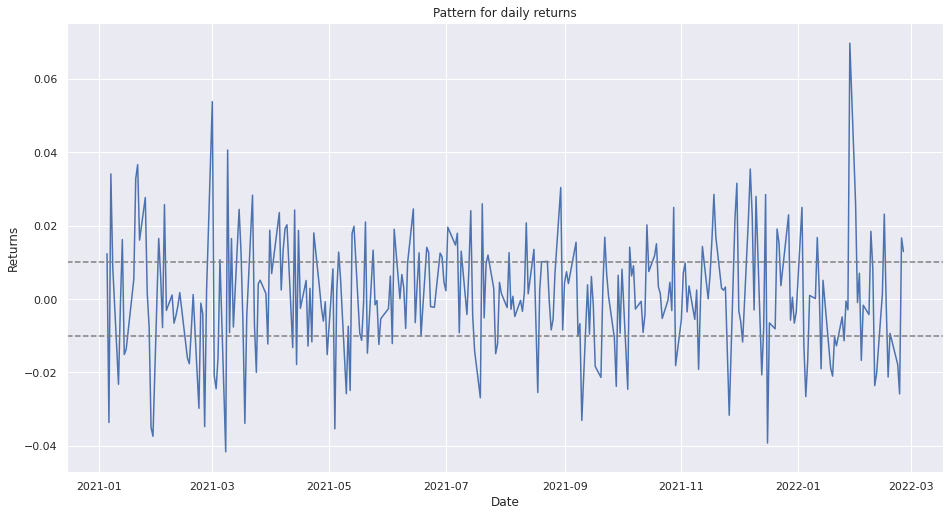

<Figure size 1130.4x595.44 with 0 Axes>

In [ ]:
# returns pattern plot
sns.set(rc={'figure.figsize':(15.7,8.27)})
ax = sns.lineplot(data=aapl_merge, x=aapl_merge.index, y='returns')
ax.set(xlabel='Date', ylabel='Returns')
ax.axhline(0.01, color="grey", ls='--')
ax.axhline(-0.01, color="grey", ls='--')
plt.title('Pattern for daily returns')
plt.show()
plt.savefig(path+'aapl_return_pattern.png')

From the above figure, we can see during time period of 2021-01-01 to 2021-04-01 and 2021-12-01 to 2022-03-01, the return fluctuates a lot.

We should pay attention to these two periods when analyzing tweets sentiment scores.

#### Sentiment scores whole period

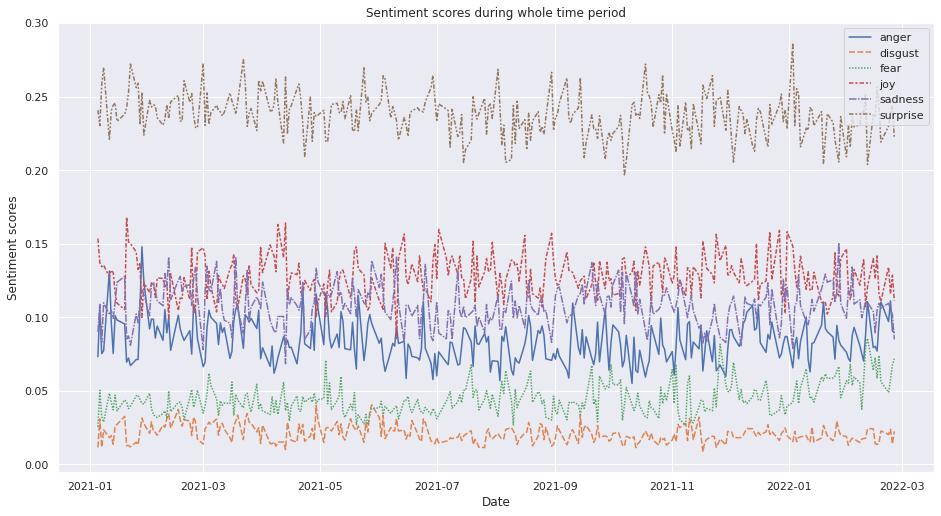

<Figure size 1130.4x595.44 with 0 Axes>

In [ ]:
ax = sns.lineplot(data = aapl_merge.drop(columns = ['neutral', 'return_type','returns']))
ax.set(xlabel='Date', ylabel='Sentiment scores')
plt.title('Sentiment scores during whole time period')
plt.show()
plt.savefig(path+'aapl_senti_scores.png')

Comments:

The avergae sentiment score for surprise is higher than other emotions. One reason can be that people are constantly expressing surprise in tweets. Another one is that when labeling sentiments deep learning model is affected by '!', if there are more '!' symbols, the surprise score is higher. However, this problem is hard to solve. Since if we drop them, we lose some sentimental information as show in the section 1. If we can get some sentiment labels for our data then fine tune the pre-trained model, we may get a more precise result.

Then I normalize these scores to find fluctuation.

In [ ]:
# standardized emotions
def z_score_standardization(series):
    return (series - series.mean()) / series.std()

aapl_merge_sd = aapl_merge.copy()
for col in ['anger', 'disgust','fear','joy','sadness','surprise']:
    aapl_merge_sd[col] = z_score_standardization(aapl_merge_sd[col])

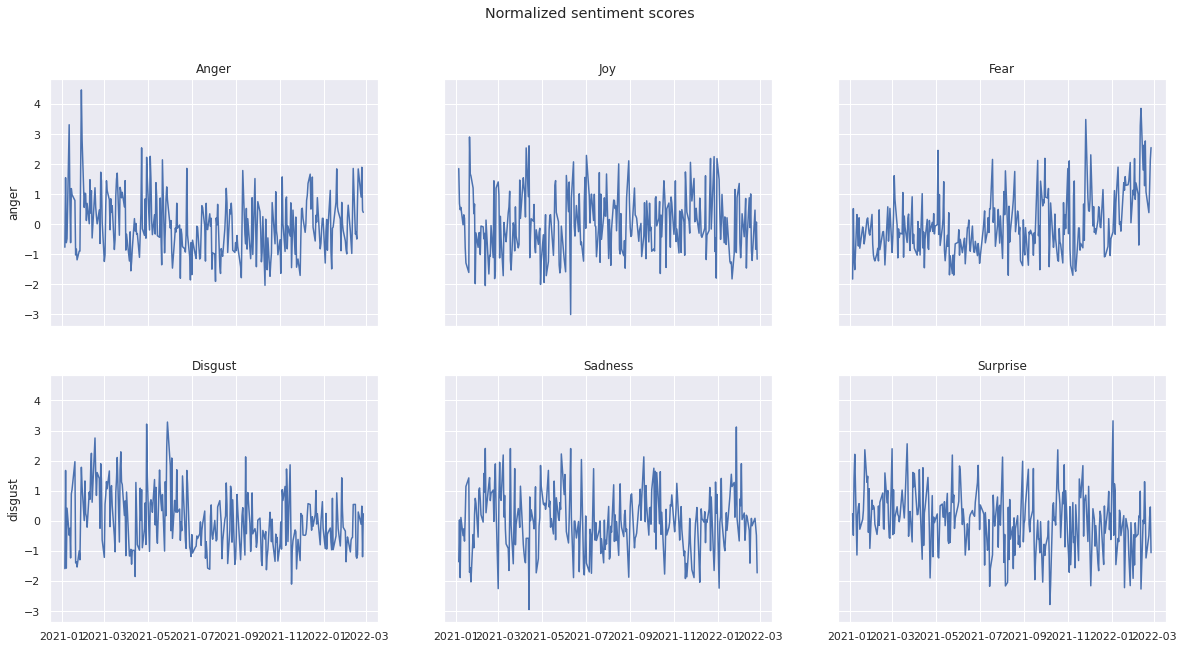

<Figure size 1130.4x595.44 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20,10), sharey=True, sharex = True)
fig.suptitle('Normalized sentiment scores')
sns.lineplot(ax=axes[0,0],data = aapl_merge_sd['anger'])
axes[0,0].set_title('Anger')

sns.lineplot(ax=axes[0,1],data = aapl_merge_sd['joy'])
axes[0,1].set_title('Joy')

sns.lineplot(ax=axes[1,0],data = aapl_merge_sd['disgust'])
axes[1,0].set_title('Disgust')

sns.lineplot(ax=axes[0,2],data = aapl_merge_sd['fear'])
axes[0,2].set_title('Fear')

sns.lineplot(ax=axes[1,1],data = aapl_merge_sd['sadness'])
axes[1,1].set_title('Sadness')

sns.lineplot(ax=axes[1,2],data = aapl_merge_sd['surprise'])
axes[1,2].set_title('Surprise')

plt.show()
plt.savefig(path+'aapl_normalized_senti.png')

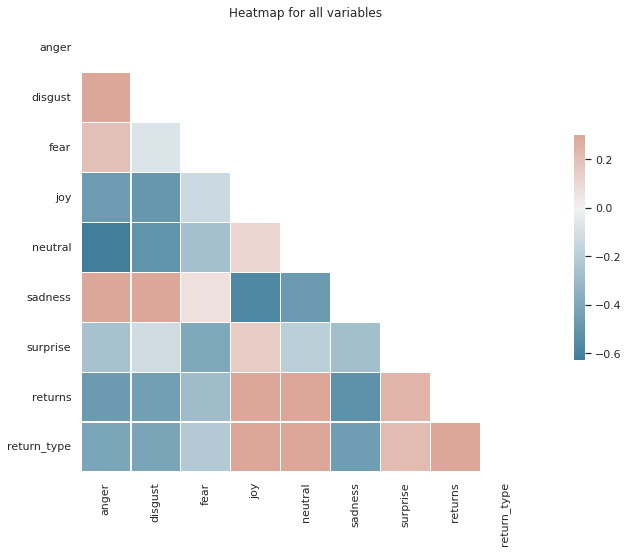

In [ ]:
# correlation matrix
sns.set_theme(style="white")
# Compute the correlation matrix
corr = aapl_merge_sd.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heatmap for all variables')
plt.savefig(path+'aapl_heatmap.png')

- We can see that when the stock returns fluctuate, people tend to show angry and disgust in tweets.

- While anger and joy fluctuate a lot it seems that the returns fluctuate a lot.

- One interesting finding is that fear and surprise remain stationary except the end of 2021. Starting from 2022, most people convey fear and surprise emotions. 


### Regression analysis

#### Same day correlation analysis.
First, we run linear regression and logistic regression on returns against sentiment scores matched in the same day.

In [ ]:
aapl_merge_sd

,anger,disgust,fear,joy,neutral,sadness,surprise,returns,return_type
2021-01-05,-0.763844,-1.591045,-1.822257,1.851949,0.405552,-1.362467,0.234960,0.012363,1.0
2021-01-06,1.547528,1.672243,0.520317,0.688570,0.336333,0.027795,-0.481545,-0.033661,0.0
2021-01-07,-0.612701,-1.574036,-1.155492,0.484622,0.405110,-1.888772,1.412825,0.034123,1.0
2021-01-08,-0.474294,0.418138,-1.509239,0.560829,0.355203,0.110456,2.209786,0.008631,1.0
2021-01-11,3.309114,-0.482538,0.322616,-0.017838,0.352653,-0.493672,-1.138733,-0.023249,0.0
...,...,...,...,...,...,...,...,...,...
2022-02-18,1.839970,0.292592,1.076996,-1.203964,0.374666,-0.166029,-1.236547,-0.009356,0.0
2022-02-22,0.905297,-0.116641,0.386882,0.470689,0.359997,0.082559,-0.491487,-0.017812,0.0
2022-02-23,1.894748,0.486413,1.185254,-0.828611,0.347066,-0.217769,0.117966,-0.025864,0.0
2022-02-24,0.457318,-1.196219,2.142124,0.073977,0.353482,-0.490563,0.459229,0.016680,1.0


In [ ]:
X = aapl_merge_sd[['anger', 'disgust','fear','joy','sadness','surprise']]
y = aapl_merge[['returns']]

In [ ]:
from statsmodels.graphics.gofplots import add_constant
X_all = add_constant(X)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
ols_results = sm.OLS(y, X_all).fit()

In [ ]:
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     34.83
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           2.09e-31
Time:                        02:14:02   Log-Likelihood:                 861.67
No. Observations:                 289   AIC:                            -1709.
Df Residuals:                     282   BIC:                            -1684.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.361      0.1

In [ ]:
# logistic regression
# building the model and fitting the data
ytrain = aapl_merge['return_type']
log_reg = sm.Logit(ytrain, X_all).fit()

Optimization terminated successfully.
         Current function value: 0.498380
         Iterations 6


In [ ]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:            return_type   No. Observations:                  289
Model:                          Logit   Df Residuals:                      282
Method:                           MLE   Df Model:                            6
Date:                Tue, 20 Dec 2022   Pseudo R-squ.:                  0.2805
Time:                        02:14:31   Log-Likelihood:                -144.03
converged:                       True   LL-Null:                       -200.18
Covariance Type:            nonrobust   LLR p-value:                 6.738e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0997      0.146      0.683      0.495      -0.186       0.386
anger         -0.3792      0.188     -2.022      0.043      -0.747      -0.012
disgust       -0.5467      0.202     -2.704      0.0

Except joy and surprise, all other emotions are significantly related to stock returns or return type.

0.7397260273972602


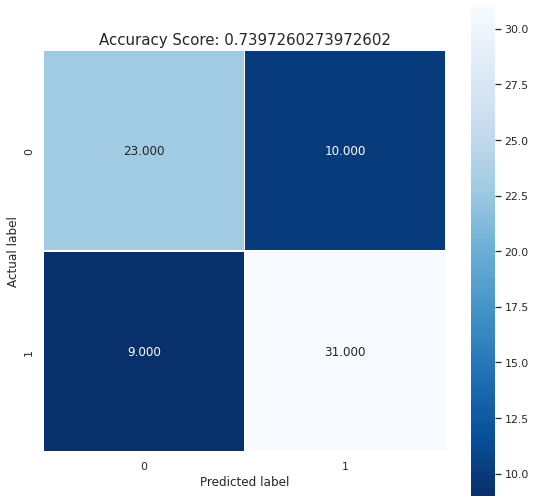

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
logisticRegr = LogisticRegression()
x_train, x_test, y_train, y_test = train_test_split(X_all, ytrain, test_size=0.25, random_state=0)
logisticRegr.fit(x_train, y_train)
# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print(score)

from sklearn import metrics
predictions = logisticRegr.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.savefig(path+'aapl_accurarcy.png')

#### Then shift one day, try to do prediction.

I match the sentiment scores and the next day stock returns to see if I can use sentiment scores to do prediction.

In [ ]:
lag_merge_aapl = pd.merge(aapl_df_lag,aapl_price, how='inner', left_index=True, right_index=True).dropna()

lag_merge_aapl_sd = lag_merge_aapl.copy()
for col in ['anger', 'disgust','fear','joy','sadness','surprise']:
    lag_merge_aapl_sd[col] = z_score_standardization(lag_merge_aapl[col])

X = lag_merge_aapl_sd[['anger', 'disgust','fear','joy','sadness','surprise']]
y = lag_merge_aapl_sd[['returns']]
X_all = add_constant(X)
ols_results = sm.OLS(y, X_all).fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.818
Date:                Tue, 20 Dec 2022   Prob (F-statistic):             0.0965
Time:                        02:29:39   Log-Likelihood:                 654.41
No. Observations:                 237   AIC:                            -1295.
Df Residuals:                     230   BIC:                            -1271.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.494      0.6

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# logistic regression
# building the model and fitting the data
ytrain = lag_merge_aapl['return_type']
log_reg = sm.Logit(ytrain, X_all).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.674259
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            return_type   No. Observations:                  237
Model:                          Logit   Df Residuals:                      230
Method:                           MLE   Df Model:                            6
Date:                Tue, 20 Dec 2022   Pseudo R-squ.:                 0.02724
Time:                        02:29:45   Log-Likelihood:                -159.80
converged:                       True   LL-Null:                       -164.27
Covariance Type:            nonrobust   LLR p-value:                    0.1765
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0106      0.132     -0.080      0.936      -0.270       0.249
anger         -0.4755      0.

0.4583333333333333


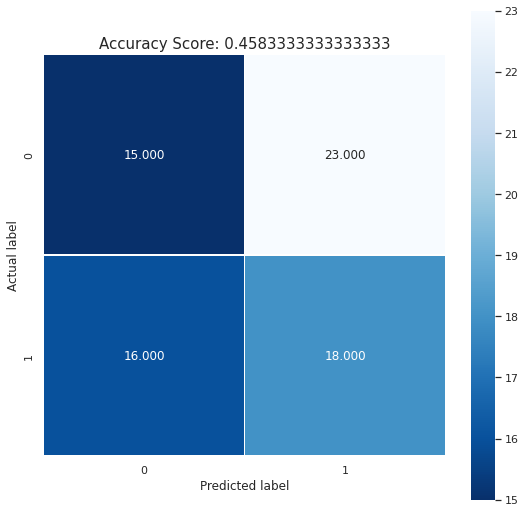

In [ ]:
logisticRegr = LogisticRegression()
x_train, x_test, y_train, y_test = train_test_split(X_all, ytrain, test_size=0.3, random_state=0)
logisticRegr.fit(x_train, y_train)
# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print(score)

from sklearn import metrics
predictions = logisticRegr.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

From the results, we find only anger emotion is statistical significant.

## TSLA data analysis

### Data decriptions

In [ ]:
# merge data
tsla_merge=pd.merge(tsla_df,tsla_price, how='inner', left_index=True, right_index=True).dropna()
# descriptions
tsla_merge.describe()

,anger,disgust,fear,joy,neutral,sadness,surprise,returns,return_type
count,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000,287.000000
mean,0.090443,0.022452,0.042998,0.127478,0.386186,0.106482,0.223961,0.000814,0.522648
std,0.011939,0.004887,0.006947,0.013137,0.016949,0.011088,0.011646,0.036447,0.500359
min,0.063254,0.012468,0.028523,0.101128,0.338727,0.077436,0.187302,-0.119903,0.000000
25%,0.082523,0.019104,0.038090,0.118450,0.376259,0.098592,0.216408,-0.020132,0.000000
50%,0.089993,0.022087,0.042252,0.126534,0.387518,0.105387,0.222752,0.001313,1.000000
75%,0.096514,0.025340,0.047176,0.136688,0.397039,0.113606,0.230636,0.019008,1.000000
max,0.148819,0.047253,0.073196,0.169729,0.434809,0.136033,0.260777,0.196412,1.000000


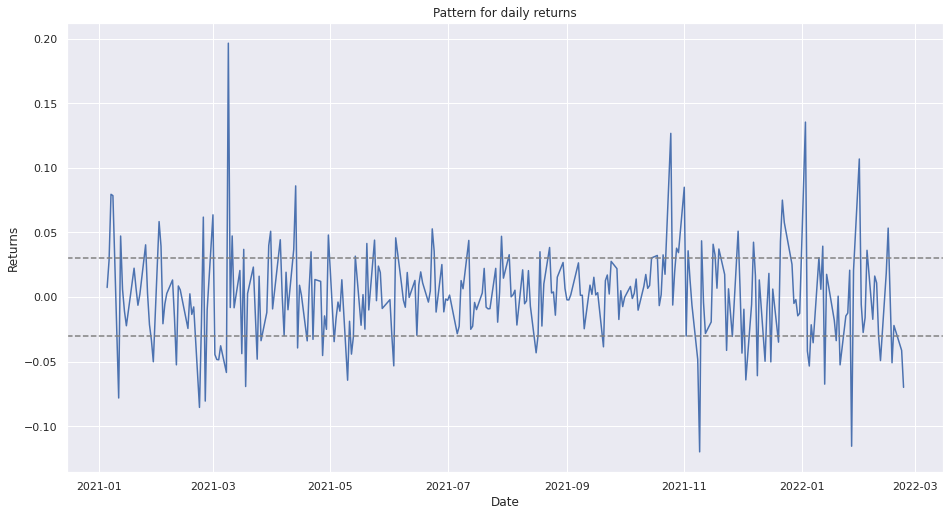

<Figure size 1130.4x595.44 with 0 Axes>

In [ ]:
# returns pattern plot
sns.set(rc={'figure.figsize':(15.7,8.27)})
ax = sns.lineplot(data=tsla_merge, x=tsla_merge.index, y='returns')
ax.set(xlabel='Date', ylabel='Returns')
ax.axhline(0.03, color="grey", ls='--')
ax.axhline(-0.03, color="grey", ls='--')
plt.title('Pattern for daily returns')
plt.show()
plt.savefig(path+'tsla_return_pattern.png')

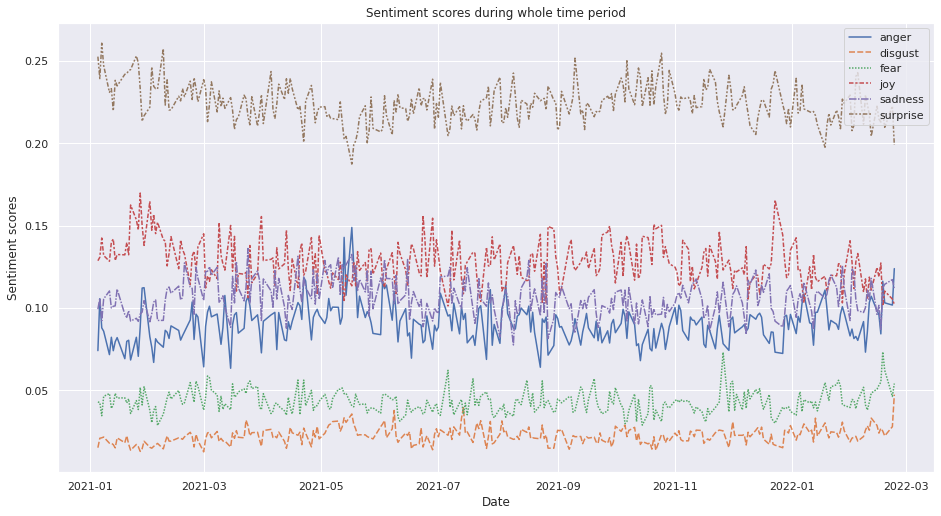

<Figure size 1130.4x595.44 with 0 Axes>

In [ ]:
ax = sns.lineplot(data = tsla_merge.drop(columns = ['neutral', 'return_type','returns']))
ax.set(xlabel='Date', ylabel='Sentiment scores')
plt.title('Sentiment scores during whole time period')
plt.show()
plt.savefig(path+'tsla_senti_scores.png')

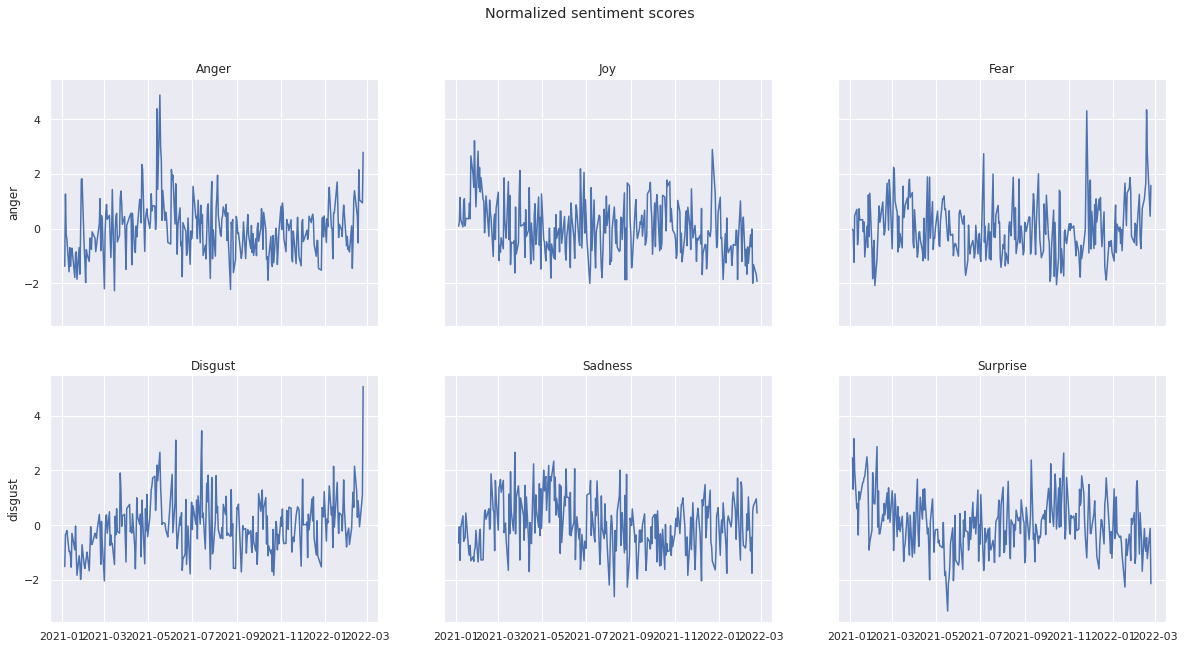

<Figure size 1130.4x595.44 with 0 Axes>

In [ ]:
tsla_merge_sd = tsla_merge.copy()
for col in ['anger', 'disgust','fear','joy','sadness','surprise']:
    tsla_merge_sd[col] = z_score_standardization(tsla_merge_sd[col])

fig, axes = plt.subplots(2, 3, figsize=(20,10), sharey=True, sharex = True)
fig.suptitle('Normalized sentiment scores')
sns.lineplot(ax=axes[0,0],data = tsla_merge_sd['anger'])
axes[0,0].set_title('Anger')

sns.lineplot(ax=axes[0,1],data = tsla_merge_sd['joy'])
axes[0,1].set_title('Joy')

sns.lineplot(ax=axes[1,0],data = tsla_merge_sd['disgust'])
axes[1,0].set_title('Disgust')

sns.lineplot(ax=axes[0,2],data = tsla_merge_sd['fear'])
axes[0,2].set_title('Fear')

sns.lineplot(ax=axes[1,1],data = tsla_merge_sd['sadness'])
axes[1,1].set_title('Sadness')

sns.lineplot(ax=axes[1,2],data = tsla_merge_sd['surprise'])
axes[1,2].set_title('Surprise')

plt.show()
plt.savefig(path+'tsla__normalized_senti.png')

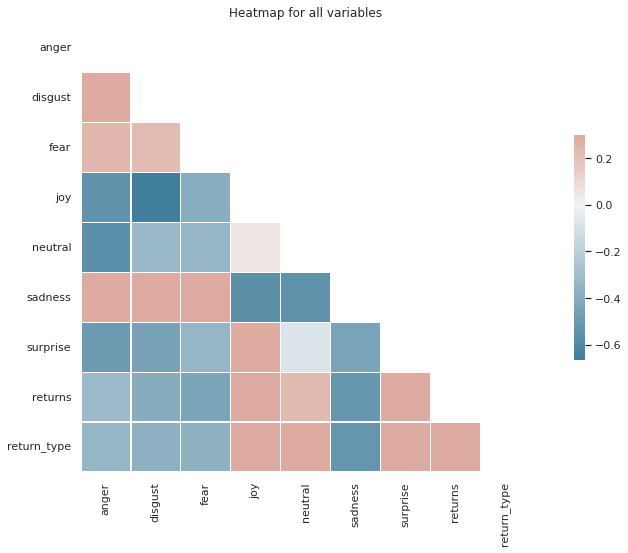

In [ ]:
# correlation matrix
sns.set_theme(style="white")
# Compute the correlation matrix
corr = tsla_merge_sd.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heatmap for all variables')
plt.savefig(path+'tsla_heatmap.png')

### Regression analysis

#### Same day correlation analysis.

In [ ]:
X = tsla_merge_sd[['anger', 'disgust','fear','joy','sadness','surprise']]
y = tsla_merge_sd[['returns']]
X_all = add_constant(X)
ols_results = sm.OLS(y, X_all).fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     30.40
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           5.07e-28
Time:                        02:27:20   Log-Likelihood:                 615.76
No. Observations:                 287   AIC:                            -1218.
Df Residuals:                     280   BIC:                            -1192.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.481      0.6

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# logistic regression
# building the model and fitting the data
ytrain = tsla_merge_sd['return_type']
log_reg = sm.Logit(ytrain, X_all).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.492834
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            return_type   No. Observations:                  287
Model:                          Logit   Df Residuals:                      280
Method:                           MLE   Df Model:                            6
Date:                Tue, 20 Dec 2022   Pseudo R-squ.:                  0.2879
Time:                        02:27:29   Log-Likelihood:                -141.44
converged:                       True   LL-Null:                       -198.64
Covariance Type:            nonrobust   LLR p-value:                 2.451e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1165      0.147      0.794      0.427      -0.171       0.404
anger         -0.0206      0.

0.7361111111111112


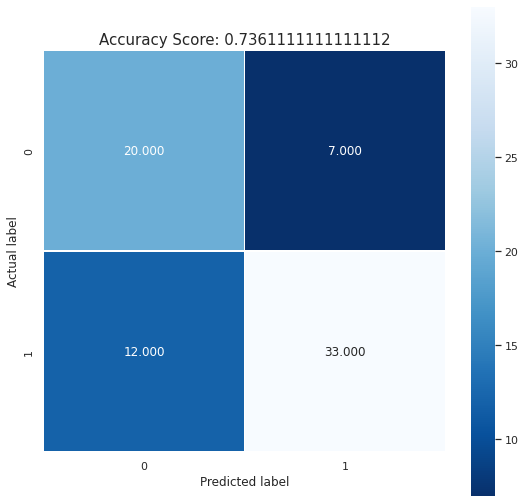

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
logisticRegr = LogisticRegression()
x_train, x_test, y_train, y_test = train_test_split(X_all, ytrain, test_size=0.25, random_state=0)
logisticRegr.fit(x_train, y_train)
# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print(score)

from sklearn import metrics
predictions = logisticRegr.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.savefig(path+'tsla_accurarcy.png')

#### Then shift one day, try to do prediction.

In [ ]:
lag_merge_tsla = pd.merge(tsla_df_lag,tsla_price, how='inner', left_index=True, right_index=True).dropna()

lag_merge_tsla_sd = lag_merge_tsla.copy()
for col in ['anger', 'disgust','fear','joy','sadness','surprise']:
    lag_merge_tsla_sd[col] = z_score_standardization(lag_merge_tsla[col])

X = lag_merge_tsla_sd[['anger', 'disgust','fear','joy','sadness','surprise']]
y = lag_merge_tsla_sd[['returns']]
X_all = add_constant(X)
ols_results = sm.OLS(y, X_all).fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8964
Date:                Tue, 20 Dec 2022   Prob (F-statistic):              0.498
Time:                        02:28:37   Log-Likelihood:                 469.04
No. Observations:                 236   AIC:                            -924.1
Df Residuals:                     229   BIC:                            -899.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.002     -0.619      0.5

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# logistic regression
# building the model and fitting the data
ytrain = lag_merge_tsla_sd['return_type']
log_reg = sm.Logit(ytrain, X_all).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.684671
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            return_type   No. Observations:                  236
Model:                          Logit   Df Residuals:                      229
Method:                           MLE   Df Model:                            6
Date:                Tue, 20 Dec 2022   Pseudo R-squ.:                 0.01218
Time:                        02:28:51   Log-Likelihood:                -161.58
converged:                       True   LL-Null:                       -163.57
Covariance Type:            nonrobust   LLR p-value:                    0.6789
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0203      0.131     -0.155      0.877      -0.278       0.237
anger         -0.0396      0.

Also not significant.

0.5084745762711864


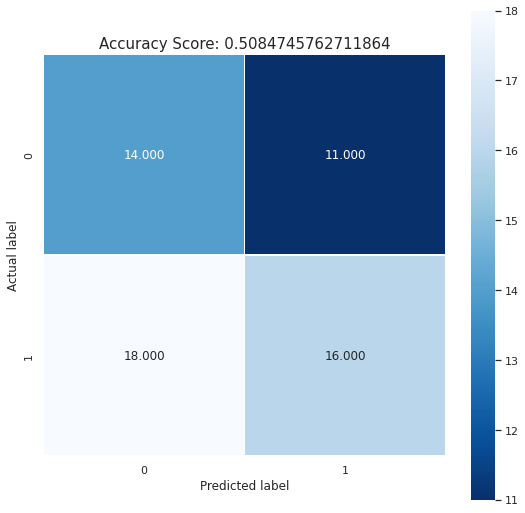

In [ ]:
logisticRegr = LogisticRegression()
x_train, x_test, y_train, y_test = train_test_split(X_all, ytrain, test_size=0.25, random_state=0)
logisticRegr.fit(x_train, y_train)
# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print(score)

from sklearn import metrics
predictions = logisticRegr.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

## AMZN data analysis

### descriptions

In [ ]:
# merge data
amzn_merge=pd.merge(amzn_df,amzn_price, how='inner', left_index=True, right_index=True).dropna()
# descriptions
amzn_merge.describe()

,anger,disgust,fear,joy,neutral,sadness,surprise,returns,return_type
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,0.085540,0.022728,0.042916,0.123258,0.370586,0.108444,0.246527,-0.000135,0.500000
std,0.017756,0.008453,0.010169,0.017235,0.024855,0.018209,0.017458,0.018585,0.500853
min,0.046155,0.006590,0.019518,0.085546,0.312539,0.064020,0.192404,-0.078128,0.000000
25%,0.073731,0.016121,0.036109,0.111003,0.350675,0.096613,0.234796,-0.010477,0.000000
50%,0.084071,0.021951,0.041793,0.121636,0.371435,0.107955,0.245699,0.000033,0.500000
75%,0.095865,0.028978,0.048922,0.135912,0.387445,0.120161,0.258879,0.010107,1.000000
max,0.170209,0.048579,0.082219,0.171402,0.446859,0.188289,0.292530,0.135359,1.000000


#### Return pattern

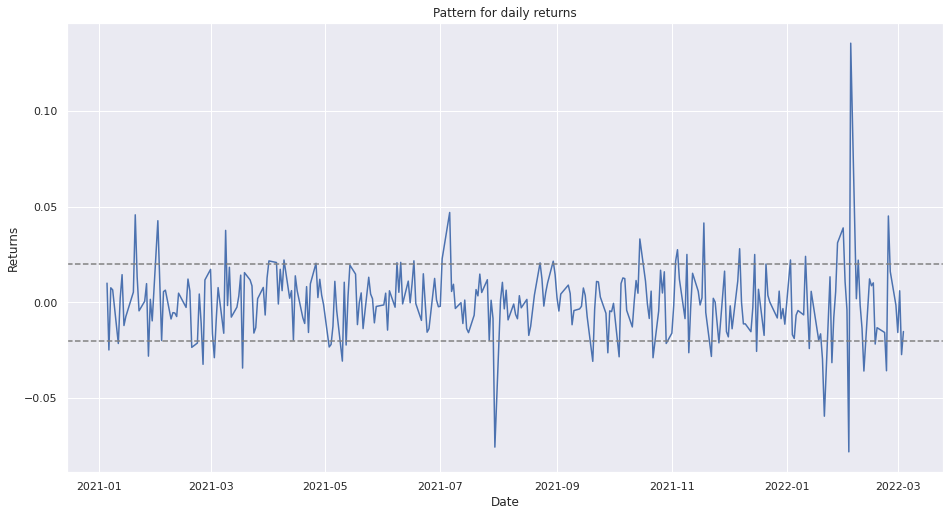

<Figure size 1130.4x595.44 with 0 Axes>

In [ ]:
# returns pattern plot
sns.set(rc={'figure.figsize':(15.7,8.27)})
ax = sns.lineplot(data=amzn_merge, x=amzn_merge.index, y='returns')
ax.set(xlabel='Date', ylabel='Returns')
ax.axhline(0.02, color="grey", ls='--')
ax.axhline(-0.02, color="grey", ls='--')
plt.title('Pattern for daily returns')
plt.show()
plt.savefig(path+'amzn_return_pattern.png')

#### Sentiment scores

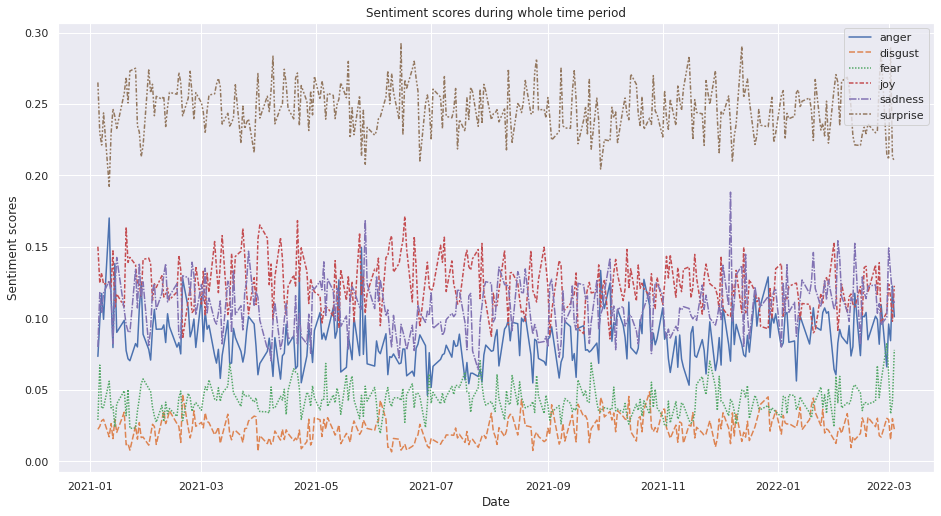

<Figure size 1130.4x595.44 with 0 Axes>

In [ ]:
ax = sns.lineplot(data = amzn_merge.drop(columns = ['neutral', 'return_type','returns']))
ax.set(xlabel='Date', ylabel='Sentiment scores')
plt.title('Sentiment scores during whole time period')
plt.show()
plt.savefig(path+'amzn_senti_scores.png')

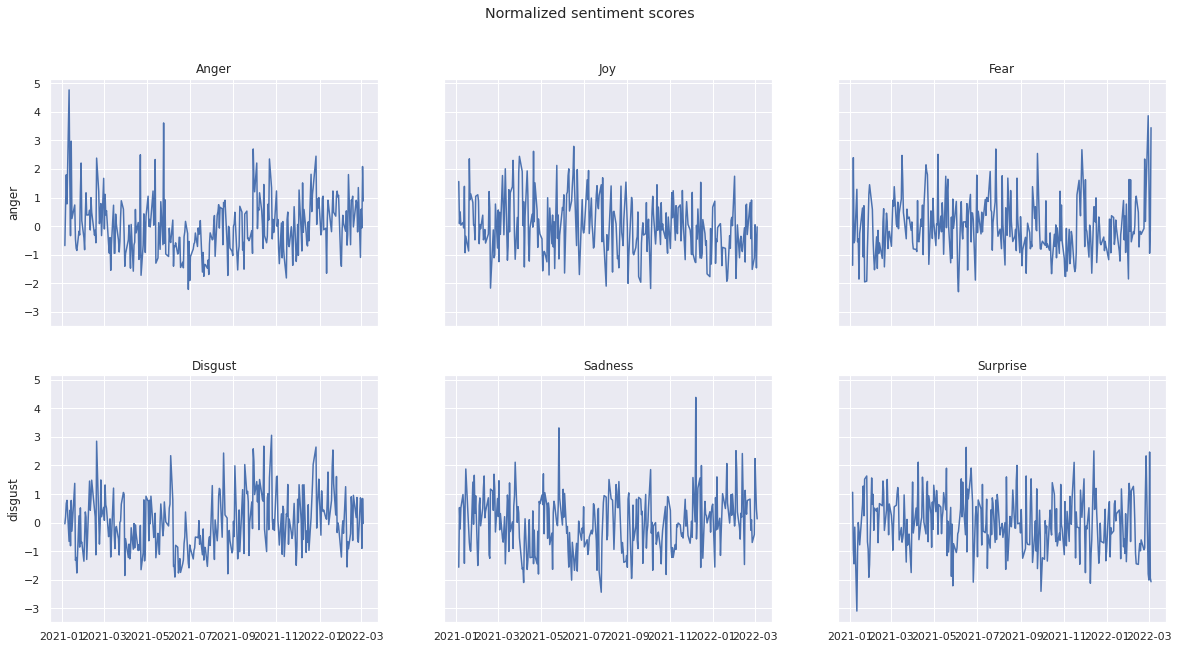

<Figure size 1130.4x595.44 with 0 Axes>

In [ ]:
amzn_merge_sd = amzn_merge.copy()
for col in ['anger', 'disgust','fear','joy','sadness','surprise']:
    amzn_merge_sd[col] = z_score_standardization(amzn_merge_sd[col])

fig, axes = plt.subplots(2, 3, figsize=(20,10), sharey=True, sharex = True)
fig.suptitle('Normalized sentiment scores')
sns.lineplot(ax=axes[0,0],data = amzn_merge_sd['anger'])
axes[0,0].set_title('Anger')

sns.lineplot(ax=axes[0,1],data = amzn_merge_sd['joy'])
axes[0,1].set_title('Joy')

sns.lineplot(ax=axes[1,0],data = amzn_merge_sd['disgust'])
axes[1,0].set_title('Disgust')

sns.lineplot(ax=axes[0,2],data = amzn_merge_sd['fear'])
axes[0,2].set_title('Fear')

sns.lineplot(ax=axes[1,1],data = amzn_merge_sd['sadness'])
axes[1,1].set_title('Sadness')

sns.lineplot(ax=axes[1,2],data = amzn_merge_sd['surprise'])
axes[1,2].set_title('Surprise')

plt.show()
plt.savefig(path+'amzn_normalized_senti.png')

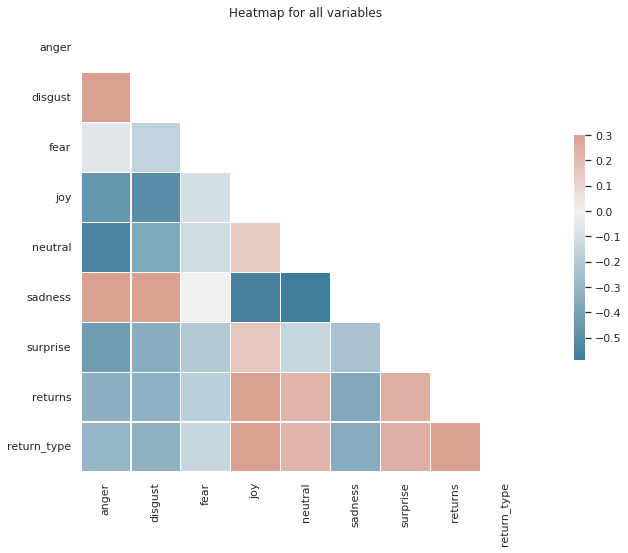

In [ ]:
# correlation matrix
sns.set_theme(style="white")
# Compute the correlation matrix
corr = amzn_merge_sd.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heatmap for all variables')
plt.savefig(path+'amzn_heatmap.png')

### Regression analysis

#### Same day correlation analysis.

In [ ]:
X = amzn_merge_sd[['anger', 'disgust','fear','joy','sadness','surprise']]
y = amzn_merge_sd[['returns']]
X_all = add_constant(X)
ols_results = sm.OLS(y, X_all).fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     16.24
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           4.24e-16
Time:                        02:31:14   Log-Likelihood:                 798.02
No. Observations:                 294   AIC:                            -1582.
Df Residuals:                     287   BIC:                            -1556.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.143      0.8

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# logistic regression
# building the model and fitting the data
ytrain = amzn_merge_sd['return_type']
log_reg = sm.Logit(ytrain, X_all).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.577820
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            return_type   No. Observations:                  294
Model:                          Logit   Df Residuals:                      287
Method:                           MLE   Df Model:                            6
Date:                Tue, 20 Dec 2022   Pseudo R-squ.:                  0.1664
Time:                        02:31:21   Log-Likelihood:                -169.88
converged:                       True   LL-Null:                       -203.79
Covariance Type:            nonrobust   LLR p-value:                 1.148e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0130      0.132      0.099      0.921      -0.245       0.271
anger         -0.1417      0.

### Add performance measurement

0.6486486486486487


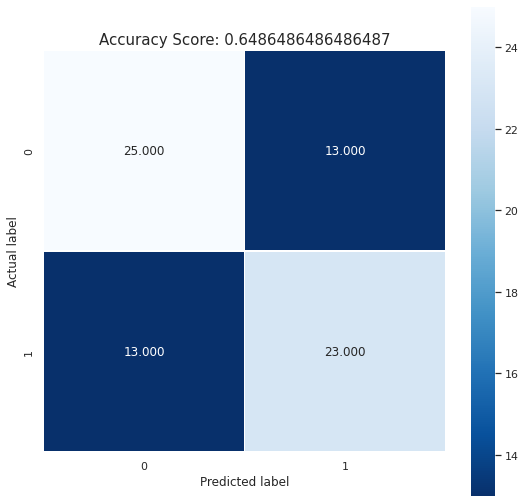

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
logisticRegr = LogisticRegression()
x_train, x_test, y_train, y_test = train_test_split(X_all, ytrain, test_size=0.25, random_state=0)
logisticRegr.fit(x_train, y_train)
# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print(score)

from sklearn import metrics
predictions = logisticRegr.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.savefig(path+'amzn_accurarcy.png')

#### Then shift one day, try to do prediction.

In [ ]:
lag_merge_amzn = pd.merge(amzn_df_lag,amzn_price, how='inner', left_index=True, right_index=True).dropna()
lag_merge_amzn_sd = lag_merge_amzn.copy()
for col in ['anger', 'disgust','fear','joy','sadness','surprise']:
    lag_merge_amzn_sd[col] = z_score_standardization(lag_merge_amzn[col])
X = lag_merge_amzn_sd[['anger', 'disgust','fear','joy','sadness','surprise']]
y = lag_merge_amzn_sd[['returns']]
X_all = add_constant(X)
ols_results = sm.OLS(y, X_all).fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9321
Date:                Tue, 20 Dec 2022   Prob (F-statistic):              0.473
Time:                        03:58:36   Log-Likelihood:                 616.42
No. Observations:                 241   AIC:                            -1219.
Df Residuals:                     234   BIC:                            -1194.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.215      0.8

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# logistic regression
# building the model and fitting the data
ytrain = lag_merge_amzn_sd['return_type']
log_reg = sm.Logit(ytrain, X_all).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.682445
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            return_type   No. Observations:                  241
Model:                          Logit   Df Residuals:                      234
Method:                           MLE   Df Model:                            6
Date:                Tue, 20 Dec 2022   Pseudo R-squ.:                 0.01543
Time:                        03:58:52   Log-Likelihood:                -164.47
converged:                       True   LL-Null:                       -167.05
Covariance Type:            nonrobust   LLR p-value:                    0.5242
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0078      0.130      0.060      0.952      -0.247       0.263
anger          0.2248      0.

0.5573770491803278


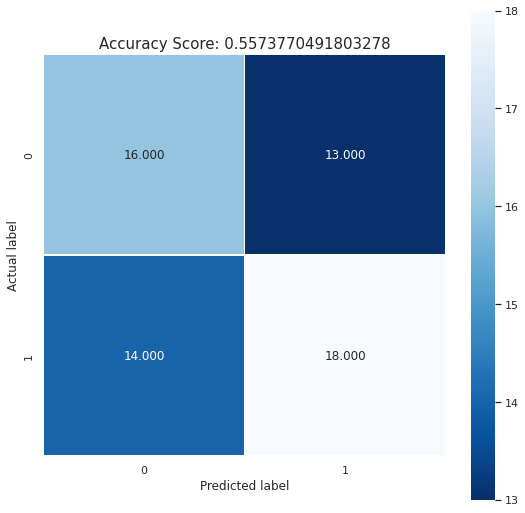

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
logisticRegr = LogisticRegression()
x_train, x_test, y_train, y_test = train_test_split(X_all, ytrain, test_size=0.25, random_state=0)
logisticRegr.fit(x_train, y_train)
# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print(score)

from sklearn import metrics
predictions = logisticRegr.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.savefig(path+'amzn_accurarcy.png')

## FB data analysis

### Descriptions


In [ ]:
# merge data
fb_merge=pd.merge(fb_df,fb_price, how='inner', left_index=True, right_index=True).dropna()
# descriptions
fb_merge.describe()

,anger,disgust,fear,joy,neutral,sadness,surprise,returns,return_type
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,0.097512,0.019116,0.052263,0.119803,0.380760,0.099404,0.231142,-0.000669,0.493197
std,0.027453,0.009803,0.019955,0.020828,0.035642,0.019996,0.027103,0.025004,0.500806
min,0.046592,0.003800,0.020681,0.071141,0.272341,0.045651,0.163147,-0.263901,0.000000
25%,0.077931,0.011325,0.038058,0.104556,0.357888,0.085576,0.213981,-0.011778,0.000000
50%,0.093752,0.017706,0.047238,0.119308,0.376581,0.098890,0.230486,-0.000218,0.000000
75%,0.113873,0.024925,0.060665,0.133856,0.405110,0.113645,0.248310,0.014011,1.000000
max,0.200616,0.051688,0.131137,0.179183,0.512288,0.163873,0.376856,0.072973,1.000000


#### Return pattern

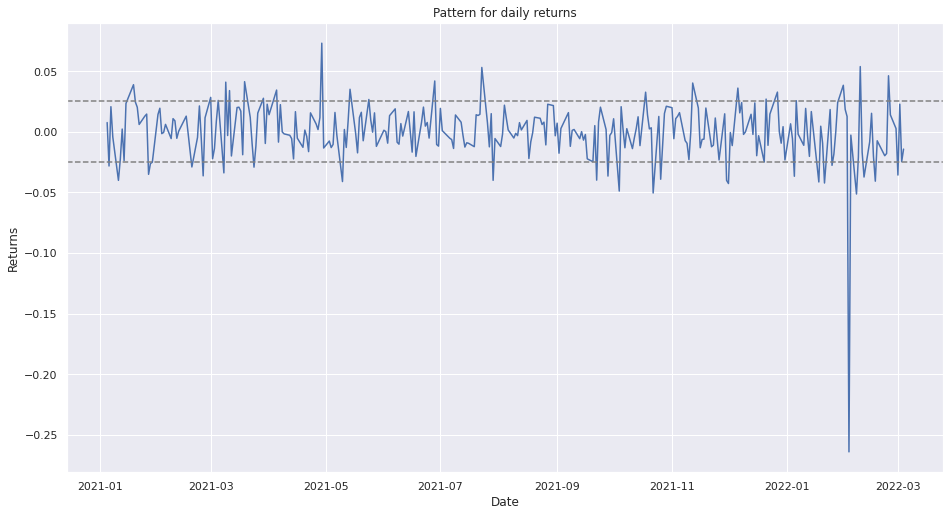

<Figure size 1130.4x595.44 with 0 Axes>

In [ ]:
# returns pattern plot
sns.set(rc={'figure.figsize':(15.7,8.27)})
ax = sns.lineplot(data=fb_merge, x=fb_merge.index, y='returns')
ax.set(xlabel='Date', ylabel='Returns')
ax.axhline(0.025, color="grey", ls='--')
ax.axhline(-0.025, color="grey", ls='--')
plt.title('Pattern for daily returns')
plt.show()
plt.savefig(path+'fb_return_pattern.png')

#### Sentiment scores

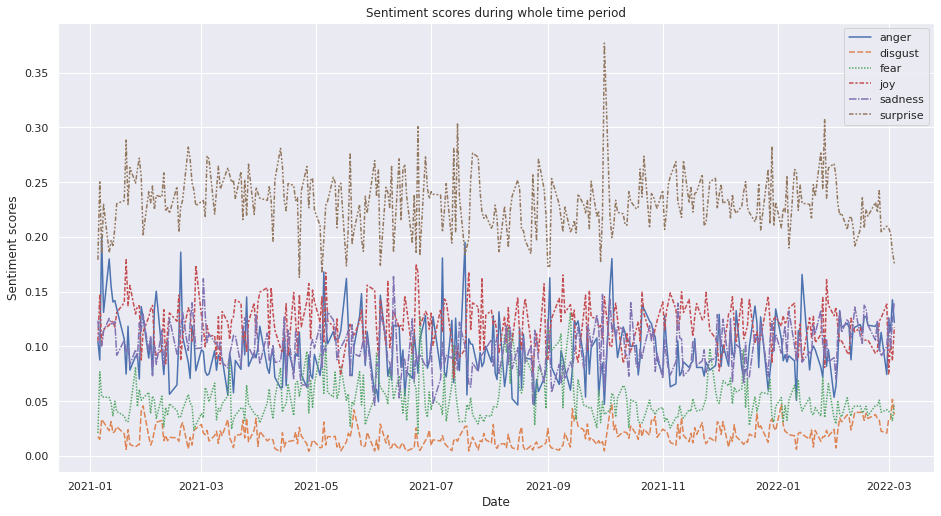

<Figure size 1130.4x595.44 with 0 Axes>

In [ ]:
ax = sns.lineplot(data = fb_merge.drop(columns = ['neutral', 'return_type','returns']))
ax.set(xlabel='Date', ylabel='Sentiment scores')
plt.title('Sentiment scores during whole time period')
plt.show()
plt.savefig(path+'fb_senti_scores.png')

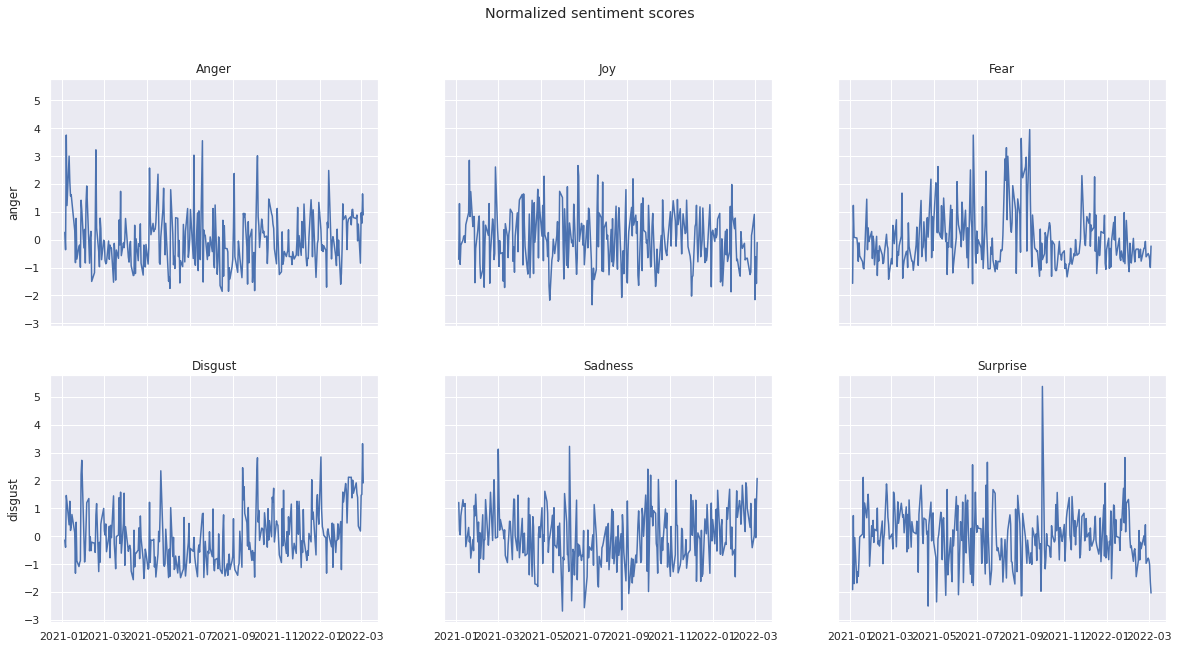

<Figure size 1130.4x595.44 with 0 Axes>

In [ ]:
fb_merge_sd = fb_merge.copy()
for col in ['anger', 'disgust','fear','joy','sadness','surprise']:
    fb_merge_sd[col] = z_score_standardization(fb_merge_sd[col])

fig, axes = plt.subplots(2, 3, figsize=(20,10), sharey=True, sharex = True)
fig.suptitle('Normalized sentiment scores')
sns.lineplot(ax=axes[0,0],data = fb_merge_sd['anger'])
axes[0,0].set_title('Anger')

sns.lineplot(ax=axes[0,1],data = fb_merge_sd['joy'])
axes[0,1].set_title('Joy')

sns.lineplot(ax=axes[1,0],data = fb_merge_sd['disgust'])
axes[1,0].set_title('Disgust')

sns.lineplot(ax=axes[0,2],data = fb_merge_sd['fear'])
axes[0,2].set_title('Fear')

sns.lineplot(ax=axes[1,1],data = fb_merge_sd['sadness'])
axes[1,1].set_title('Sadness')

sns.lineplot(ax=axes[1,2],data = fb_merge_sd['surprise'])
axes[1,2].set_title('Surprise')

plt.show()
plt.savefig(path+'fb_normalized_senti.png')

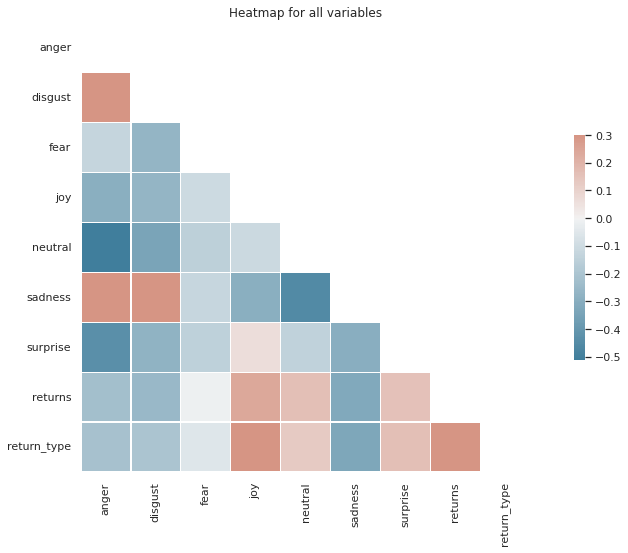

In [ ]:
# correlation matrix
sns.set_theme(style="white")
# Compute the correlation matrix
corr = fb_merge_sd.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heatmap for all variables')
plt.savefig(path+'fb_heatmap.png')

### Regression analysis

#### Same day correlation analysis.

In [ ]:
X = fb_merge_sd[['anger', 'disgust','fear','joy','sadness','surprise']]
y = fb_merge_sd[['returns']]
X_all = add_constant(X)
ols_results = sm.OLS(y, X_all).fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     8.126
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           4.01e-08
Time:                        02:32:42   Log-Likelihood:                 690.88
No. Observations:                 294   AIC:                            -1368.
Df Residuals:                     287   BIC:                            -1342.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.491      0.6

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# logistic regression
# building the model and fitting the data
ytrain = fb_merge_sd['return_type']
log_reg = sm.Logit(ytrain, X_all).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.603552
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            return_type   No. Observations:                  294
Model:                          Logit   Df Residuals:                      287
Method:                           MLE   Df Model:                            6
Date:                Tue, 20 Dec 2022   Pseudo R-squ.:                  0.1291
Time:                        02:32:55   Log-Likelihood:                -177.44
converged:                       True   LL-Null:                       -203.76
Covariance Type:            nonrobust   LLR p-value:                 1.394e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0297      0.128     -0.232      0.816      -0.281       0.221
anger         -0.1156      0.

Results are not very significant compared to other stocks. It may because less people talk about facebook stock on twitter. Or may due to facebook stock price is not driven by individual investors.

### Add performance measurement

0.6621621621621622


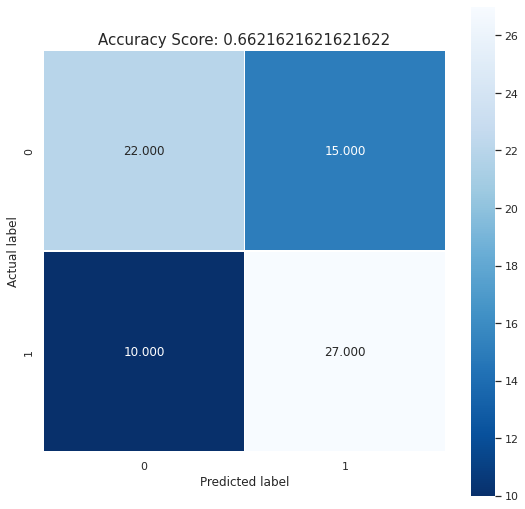

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
logisticRegr = LogisticRegression()
x_train, x_test, y_train, y_test = train_test_split(X_all, ytrain, test_size=0.25, random_state=0)
logisticRegr.fit(x_train, y_train)
# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print(score)

from sklearn import metrics
predictions = logisticRegr.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.savefig(path+'fb_accurarcy.png')

#### Predict next day.

In [ ]:
lag_merge_fb = pd.merge(fb_df_lag,fb_price, how='inner', left_index=True, right_index=True).dropna()
lag_merge_fb_sd = lag_merge_fb.copy()
for col in ['anger', 'disgust','fear','joy','sadness','surprise']:
    lag_merge_fb_sd[col] = z_score_standardization(lag_merge_fb[col])
X = lag_merge_fb_sd[['anger', 'disgust','fear','joy','sadness','surprise']]
y = lag_merge_fb_sd[['returns']]
X_all = add_constant(X)
ols_results = sm.OLS(y, X_all).fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.6234
Date:                Tue, 20 Dec 2022   Prob (F-statistic):              0.712
Time:                        02:33:48   Log-Likelihood:                 544.35
No. Observations:                 241   AIC:                            -1075.
Df Residuals:                     234   BIC:                            -1050.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.002     -0.956      0.3

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# logistic regression
# building the model and fitting the data
ytrain = lag_merge_fb_sd['return_type']
log_reg = sm.Logit(ytrain, X_all).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.684732
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            return_type   No. Observations:                  241
Model:                          Logit   Df Residuals:                      234
Method:                           MLE   Df Model:                            6
Date:                Tue, 20 Dec 2022   Pseudo R-squ.:                 0.01006
Time:                        02:33:55   Log-Likelihood:                -165.02
converged:                       True   LL-Null:                       -166.70
Covariance Type:            nonrobust   LLR p-value:                    0.7632
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1089      0.130     -0.838      0.402      -0.364       0.146
anger          0.2002      0.

0.5081967213114754


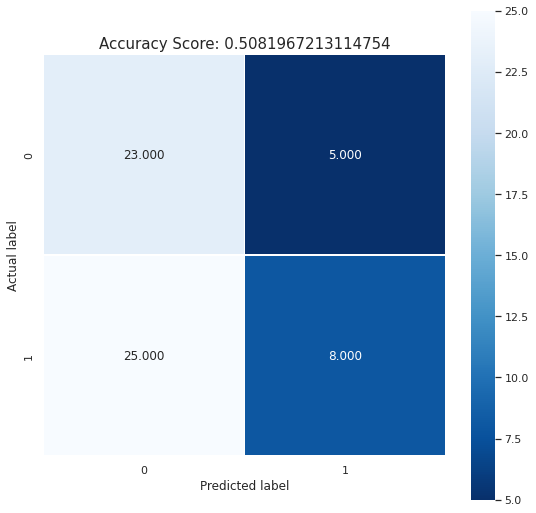

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
logisticRegr = LogisticRegression()
x_train, x_test, y_train, y_test = train_test_split(X_all, ytrain, test_size=0.25, random_state=0)
logisticRegr.fit(x_train, y_train)
# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print(score)

from sklearn import metrics
predictions = logisticRegr.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.savefig(path+'fb_accurarcy.png')

## NVDA data analysis


### Descriptions

In [ ]:
# merge data
nvda_merge=pd.merge(nvda_df,nvda_price, how='inner', left_index=True, right_index=True).dropna()
# descriptions
nvda_merge.describe()

,anger,disgust,fear,joy,neutral,sadness,surprise,returns,return_type
count,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000
mean,0.074859,0.018775,0.052299,0.125964,0.396785,0.100455,0.230863,0.002596,0.534483
std,0.020118,0.008836,0.020720,0.023051,0.040329,0.021568,0.026623,0.030208,0.499672
min,0.022249,0.002709,0.010967,0.062312,0.289499,0.050071,0.136359,-0.082178,0.000000
25%,0.061563,0.012296,0.039109,0.111722,0.370664,0.085683,0.212937,-0.013419,0.000000
50%,0.073371,0.017537,0.048969,0.125527,0.399062,0.099917,0.230435,0.002670,1.000000
75%,0.088337,0.024422,0.061106,0.138457,0.421330,0.114853,0.246982,0.020020,1.000000
max,0.136281,0.053060,0.197056,0.192320,0.499471,0.209984,0.311772,0.120423,1.000000


#### Return pattern

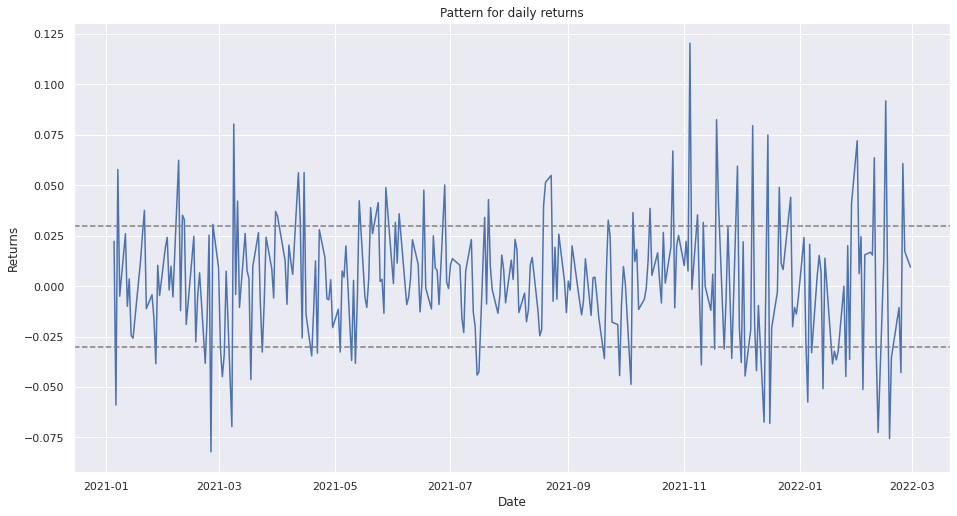

<Figure size 1130.4x595.44 with 0 Axes>

In [ ]:
# returns pattern plot
sns.set(rc={'figure.figsize':(15.7,8.27)})
ax = sns.lineplot(data=nvda_merge, x=nvda_merge.index, y='returns')
ax.set(xlabel='Date', ylabel='Returns')
ax.axhline(0.03, color="grey", ls='--')
ax.axhline(-0.03, color="grey", ls='--')
plt.title('Pattern for daily returns')
plt.show()
plt.savefig(path+'nvda_return_pattern.png')

#### Sentiment scores

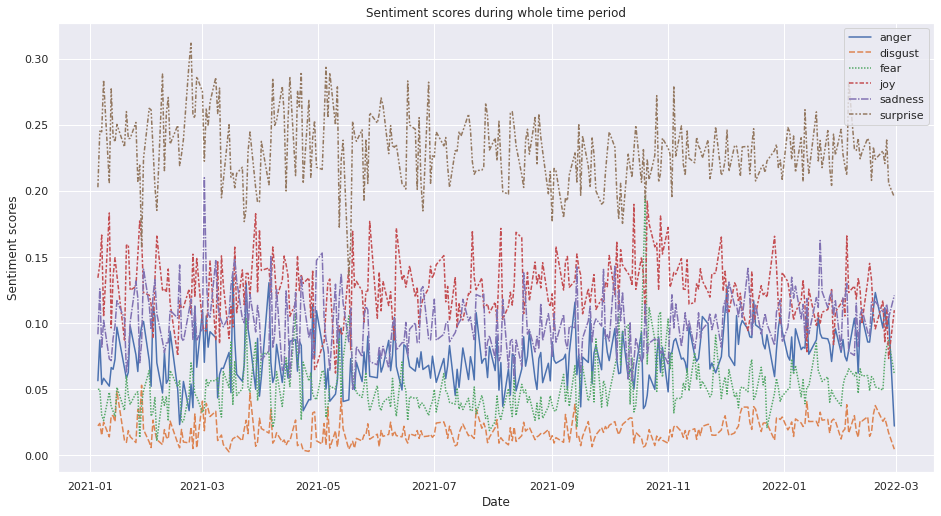

<Figure size 1130.4x595.44 with 0 Axes>

In [ ]:
ax = sns.lineplot(data = nvda_merge.drop(columns = ['neutral', 'return_type','returns']))
ax.set(xlabel='Date', ylabel='Sentiment scores')
plt.title('Sentiment scores during whole time period')
plt.show()
plt.savefig(path+'nvda_senti_scores.png')

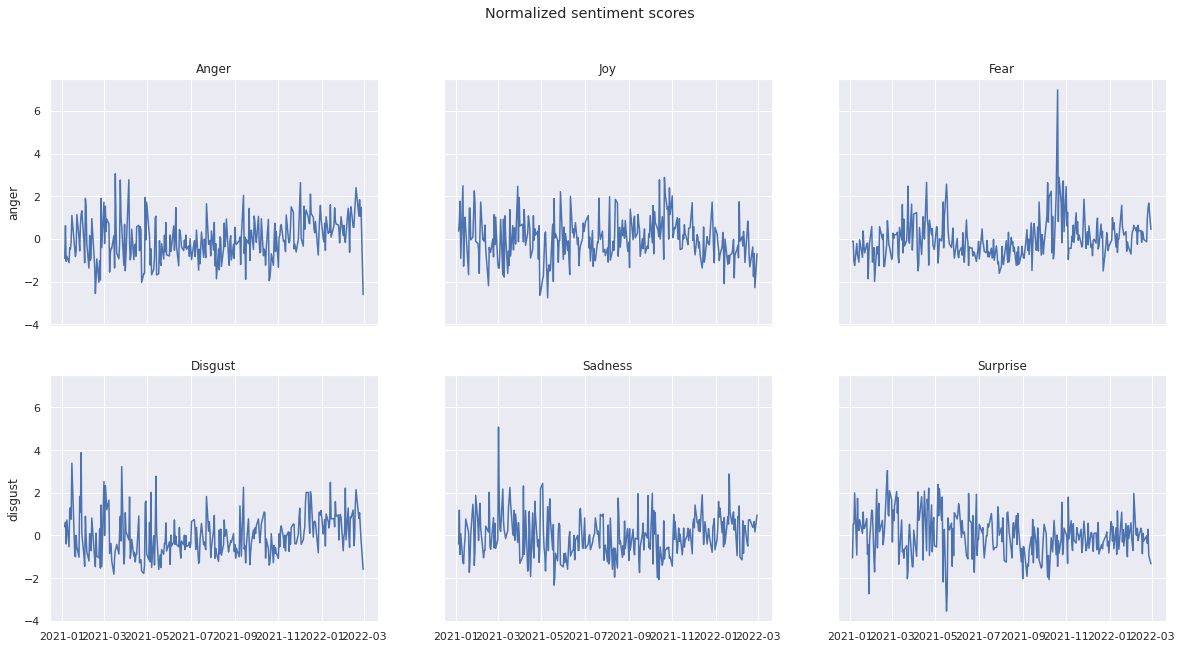

<Figure size 1130.4x595.44 with 0 Axes>

In [ ]:
nvda_merge_sd = nvda_merge.copy()
for col in ['anger', 'disgust','fear','joy','sadness','surprise']:
    nvda_merge_sd[col] = z_score_standardization(nvda_merge_sd[col])

fig, axes = plt.subplots(2, 3, figsize=(20,10), sharey=True, sharex = True)
fig.suptitle('Normalized sentiment scores')
sns.lineplot(ax=axes[0,0],data = nvda_merge_sd['anger'])
axes[0,0].set_title('Anger')

sns.lineplot(ax=axes[0,1],data = nvda_merge_sd['joy'])
axes[0,1].set_title('Joy')

sns.lineplot(ax=axes[1,0],data = nvda_merge_sd['disgust'])
axes[1,0].set_title('Disgust')

sns.lineplot(ax=axes[0,2],data = nvda_merge_sd['fear'])
axes[0,2].set_title('Fear')

sns.lineplot(ax=axes[1,1],data = nvda_merge_sd['sadness'])
axes[1,1].set_title('Sadness')

sns.lineplot(ax=axes[1,2],data = nvda_merge_sd['surprise'])
axes[1,2].set_title('Surprise')

plt.show()
plt.savefig(path+'nvda_normalized_senti.png')

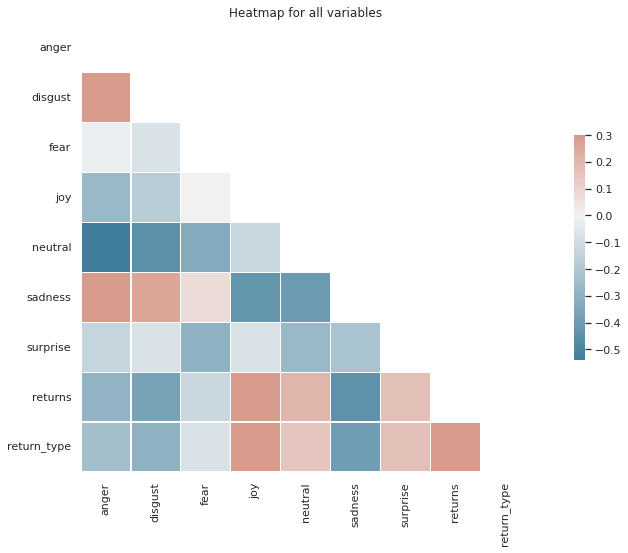

In [ ]:
# correlation matrix
sns.set_theme(style="white")
# Compute the correlation matrix
corr = nvda_merge_sd.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heatmap for all variables')
plt.savefig(path+'nvda_heatmap.png')

### Regression analysis

#### Same day

In [ ]:
X = nvda_merge_sd[['anger', 'disgust','fear','joy','sadness','surprise']]
y = nvda_merge_sd[['returns']]
X_all = add_constant(X)
ols_results = sm.OLS(y, X_all).fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     21.21
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           1.53e-20
Time:                        02:35:11   Log-Likelihood:                 657.76
No. Observations:                 290   AIC:                            -1302.
Df Residuals:                     283   BIC:                            -1276.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      1.744      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# logistic regression
# building the model and fitting the data
ytrain = nvda_merge_sd['return_type']
log_reg = sm.Logit(ytrain, X_all).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.563945
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            return_type   No. Observations:                  290
Model:                          Logit   Df Residuals:                      283
Method:                           MLE   Df Model:                            6
Date:                Tue, 20 Dec 2022   Pseudo R-squ.:                  0.1836
Time:                        02:35:19   Log-Likelihood:                -163.54
converged:                       True   LL-Null:                       -200.32
Covariance Type:            nonrobust   LLR p-value:                 7.604e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1738      0.135      1.288      0.198      -0.091       0.438
anger          0.0395      0.

### Add performance measurement

0.6438356164383562


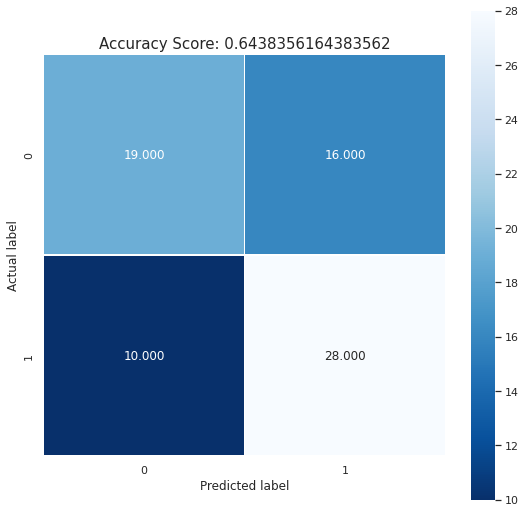

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
logisticRegr = LogisticRegression()
x_train, x_test, y_train, y_test = train_test_split(X_all, ytrain, test_size=0.25, random_state=0)
logisticRegr.fit(x_train, y_train)
# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print(score)

from sklearn import metrics
predictions = logisticRegr.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.savefig(path+'nvda_accurarcy.png')

#### Next day

In [ ]:
lag_merge_nvda = pd.merge(nvda_df_lag,nvda_price, how='inner', left_index=True, right_index=True).dropna()
lag_merge_nvda_sd = lag_merge_nvda.copy()
for col in ['anger', 'disgust','fear','joy','sadness','surprise']:
    lag_merge_nvda_sd[col] = z_score_standardization(lag_merge_nvda[col])
X = lag_merge_nvda_sd[['anger', 'disgust','fear','joy','sadness','surprise']]
y = lag_merge_nvda_sd[['returns']]
X_all = add_constant(X)
ols_results = sm.OLS(y, X_all).fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.2614
Date:                Tue, 20 Dec 2022   Prob (F-statistic):              0.954
Time:                        02:36:18   Log-Likelihood:                 498.08
No. Observations:                 238   AIC:                            -982.2
Df Residuals:                     231   BIC:                            -957.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      0.851      0.3

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# logistic regression
# building the model and fitting the data
ytrain = lag_merge_nvda_sd['return_type']
log_reg = sm.Logit(ytrain, X_all).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.689900
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            return_type   No. Observations:                  238
Model:                          Logit   Df Residuals:                      231
Method:                           MLE   Df Model:                            6
Date:                Tue, 20 Dec 2022   Pseudo R-squ.:                0.003415
Time:                        02:36:25   Log-Likelihood:                -164.20
converged:                       True   LL-Null:                       -164.76
Covariance Type:            nonrobust   LLR p-value:                    0.9804
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0844      0.130      0.649      0.516      -0.171       0.339
anger          0.0251      0.

0.4


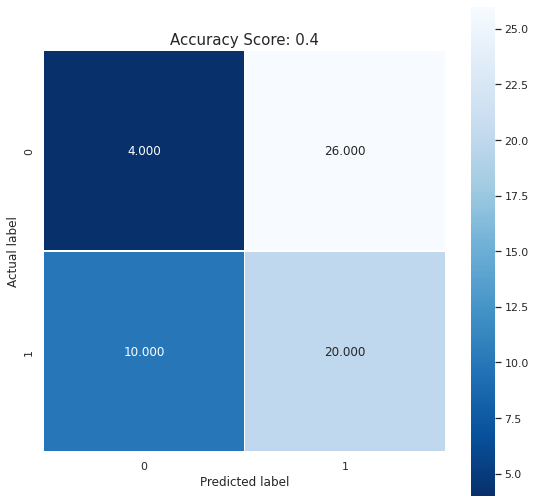

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
logisticRegr = LogisticRegression()
x_train, x_test, y_train, y_test = train_test_split(X_all, ytrain, test_size=0.25, random_state=0)
logisticRegr.fit(x_train, y_train)
# Use score method to get accuracy of model
score = logisticRegr.score(x_test, y_test)
print(score)

from sklearn import metrics
predictions = logisticRegr.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
plt.savefig(path+'nvda_accurarcy.png')

## Compare sentiment across different stocks

Boxplot

In [ ]:
all_data = pd.concat([aapl_df, tsla_df, fb_df, amzn_df, nvda_df],ignore_index = False,
                           sort = False)

In [ ]:
all_data = all_data.melt(id_vars=['stock'],value_vars = ['anger', 'disgust','fear','joy','sadness','surprise','neutral'],
              value_name='emotion')

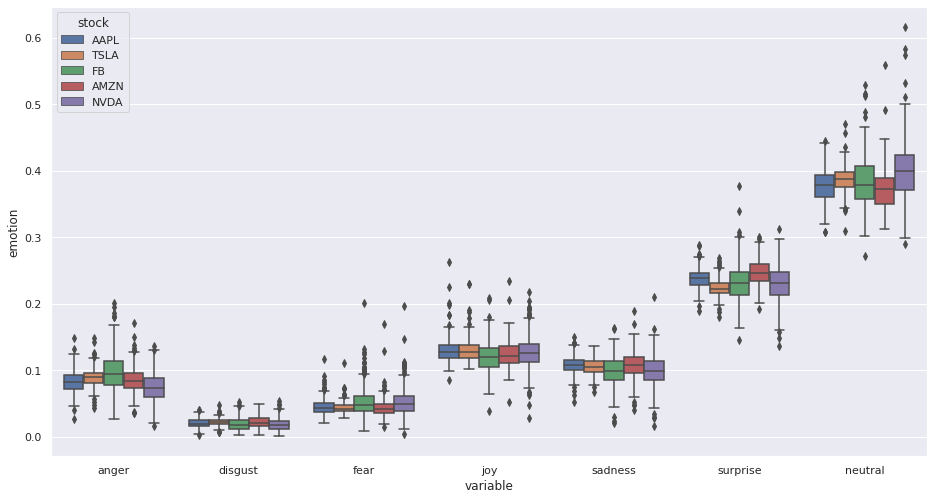

In [ ]:
sns.boxplot(x = 'variable',y = 'emotion',data = all_data, hue = 'stock' )
plt.savefig(path+'all_stock_senti.png')

For different stocks, try to compare across emotions and find if people's feelings tend to vary. 

## Conclusion

1. A very strong finding is that tweets sentiments are strongly correlated to the same day stock return pattern. People convey related feeling as a reaction to the present stock market trend. However, we cannot simply use sentiment analysis result to predict next day returns and make money. The prediction model need to be improved and add more features.

2. When looking at people's emotions, we can guess what happened in a certain period. For example, by the end of 2021, people had a high fear score, and during that time, the stock prices went down a lot. 

In [ ]:
%%shell
jupyter nbconvert --to html /content/nlp_project_part3.ipynb

[NbConvertApp] Converting notebook /content/nlp_project_part3.ipynb to html
[NbConvertApp] Writing 3945608 bytes to /content/nlp_project_part3.html
